<a href="https://colab.research.google.com/github/nk106/Collision-Prediction-RL/blob/main/cse571_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1

/content/drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1


In [ ]:
#Python libraries: cython matplotlib sklearn scipy pymunk pygame pillow numpy noise torch
!pip install pymunk==5.7.0
!pip install noise
!pip install pillow
!pip install pygame

     |████████████████████████████████| 538 kB 5.2 MB/s 
     |████████████████████████████████| 132 kB 5.2 MB/s 
  Created wheel for noise: filename=noise-1.2.2-cp37-cp37m-linux_x86_64.whl size=64368 sha256=96458030d96a5536d0a5b6babb8932c8a15d22cf84c4d2e36d118c66470a4fa7
  Stored in directory: /root/.cache/pip/wheels/50/4f/1d/3e94460751c993553ba1a52b8e571ba6510701b4d0a68ffeea
Successfully built noise
     |████████████████████████████████| 18.3 MB 1.2 MB/s 


In [ ]:
!pip uninstall scikit-learn -y
!pip install scikit-learn==0.21.1

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import os

os.environ['SDL_VIDEODRIVER'] = 'dummy'

In [ ]:
#@title testing numpy array concnat stuff 
import numpy as np
tAy = [1,2,3,4,5,6,7]
print(tAy)
bAy = 100
cAy = [200]

dAy = np.asarray(bAy)
print (dAy)
#cncat = np.concatenate((tAy,dAy,cAy))
cncat = np.append(tAy,bAy)
dncat = cncat 

cncat.append(tAy)
print("cncat: ")
print(cncat)
print("cncat: ")

#apxay = np.apply_along_axis(cncat,cncat)
apxay = np.vstack((cncat,cncat))
print(apxay)

print('')
stckA = np.vstack((apxay,cncat))
print(stckA)

print('')
stckB = np.vstack((stckA,stckA))
print(stckB)

stckB[-1][-1] = 9
print(stckB)

In [ ]:
empy = [0]*9
empy = (np.vstack((empy,stckB)))
print(empy)



```
# This is formatted as code
```

#Submit only 100 samps BUT need to TRAIN on FAR MORE!!

In [ ]:
#@title **MAY NEED TO ACTUALLY USE TO SUBMIT??** Data Collection --> CSV .py
# ************** STUDENTS EDIT THIS FILE **************
### ****************************************************************Collect_Data.py*********
from SteeringBehaviors import Wander
import SimulationEnvironment as sim
import numpy as np

def collect_training_data(total_actions):
    #set-up environment
    sim_env = sim.SimulationEnvironment()

    #robot control
    action_repeat = 100
    steering_behavior = Wander(action_repeat)

    num_params = 7
    #STUDENTS: network_params will be used to store your training data
    # a single sample will be comprised of: sensor_readings, action, collision
    network_params = [0]*7


    for action_i in range(total_actions):
        progress = 100*float(action_i)/total_actions
        print(f'Collecting Training Data {progress}%   ', end="\r", flush=True)

        #steering_force is used for robot control only
        action, steering_force = steering_behavior.get_action(action_i, sim_env.robot.body.angle)

        for action_timestep in range(action_repeat):
            if action_timestep == 0:
                _, collision, sensor_readings = sim_env.step(steering_force)
                # print(action_i)       #test
                # print(sensor_readings)#test
            else:
                _, collision, _ = sim_env.step(steering_force)

            if collision:
                steering_behavior.reset_action()
                #STUDENTS NOTE: this statement only EDITS collision of PREVIOUS action
                #if current action is very new.
                if action_timestep < action_repeat * .3: #in case prior action caused collision
                    print("******* collision Prior ******* ")
                    network_params[-1][-1] = collision

          #UNCOMMENT-->          network_params[-1][-1] = collision #share collision result with prior action
                    # print("Collision: "+str(collision))
                    # print("action_timestep"+str(action_timestep))
                    # print("action: "+str(action))
                break


        #STUDENTS: Update network_params.
        sensor_readings = np.append(sensor_readings,action)
        sensor_readings = np.append(sensor_readings,collision)
        network_params = np.vstack((network_params,sensor_readings))


        # print("Action i: "+str(action_i))       #test
        # print("Sensor Readings: "+str(sensor_readings))#test
        # print("action: "+str(action))
        # print("Collision: "+str(collision))


    #ANSWER HERE:   network_params = [sensor_readings][action][collision]


    #STUDENTS: Save .csv here. Remember rows are individual samples, the first 5
    #columns are sensor values, the 6th is the action, and the 7th is collision.
    #Do not title the columns. Your .csv should look like the provided sample.

    print(network_params)




if __name__ == '__main__':
    total_actions = 100
    collect_training_data(total_actions)


In [ ]:
with open("saved/2500_samps.csv","r") as source:
    lines = [line for line in source]


In [ ]:
import random
random_choice = random.sample(lines, 100)

with open("100_samps.csv", "w") as sink:
    sink.write("".join(random_choice))



In [ ]:
#CSV given has 11000 Rows(!), 7 columns

In [ ]:
print(network_params)

In [ ]:
!pip install scikit-learn==0.21.1

     |████████████████████████████████| 6.7 MB 5.2 MB/s 


In [ ]:
#@title train-test-split DataLoader.py
import torch
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import train_test_split #added.. for now


class Nav_Dataset(dataset.Dataset):
    def __init__(self):
       #UNCOMMENT self.data = np.genfromtxt('saved/training_data.csv', delimiter=',')
      #OLDnk 
      self.data = np.genfromtxt('saved/testsheet.csv', delimiter=',')
      
# STUDENTS: it may be helpful for the final part to balance the distribution of your collected data

        # normalize data and save scaler for inference
       self.scaler = MinMaxScaler()
       self.normalized_data = self.scaler.fit_transform(self.data) #fits and transforms
       pickle.dump(self.scaler, open("saved/scaler.pkl", "wb")) #save to normalize at inference

    def __len__(self):
# STUDENTS: __len__() returns the length of the dataset
        return(len(self.data))
        #pass

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
# STUDENTS: for this example, __getitem__() must return a dict with entries {'input': x, 'label': y}
# x and y should both be of type float32. There are many other ways to do this, but to work with autograding
# please do not deviate from these specifications.

      #i think i need to Define a Dictionary? where X[6] = Input and Y[1] = Output, and then Return that Dict? 
      #but what does 'idx' do? WHat's the difference between "item()" && "items()"!? 
      #idx.item is a  
        x = idx   #should this be 'normalized_data' or just data?? 
        #y = self.normalized_data[idx]# OR self.normalized_data.idx???
        y = self.data[idx]
        returndict = {'input':idx,'label':y}    #for some reason i had to reverse x & y here....
        return(returndict)
        #return(self.normalized_data.idx)
  # the get item function should work on the normalized data as later on that its what would be fed as input 
  #WHAT ARE THE INPUTS!?!? IT IS THE ARRAY ----- forget this: is it the whole array of 6 values or just 1 index value? instructions say x should be type float32.. can it be an array type float32? 


class Data_Loaders():
    def __init__(self, batch_size):
        self.nav_dataset = Nav_Dataset()
# STUDENTS: randomly split dataset into two data.DataLoaders, self.train_loader and self.test_loader
# make sure your split can handle an arbitrary number of samples in the dataset as this may vary
        # test_size = int((len(self.nav_dataset))*0.2)
        # train_size = len(self.nav_dataset) - test_size  

        #from Large Matrix to Smaller One: smaller = larger[startRow:startRow+size,startCol:startCol+size]
                      #i think this is the Matrix i should be using? 
        inputs = self.nav_dataset.data[0:len(self.nav_dataset),0:6]  #i think this is right?? not sure if Cols should be 0:5 or 1:6
                                                #am i using .len correctly?  
        outputs = self.nav_dataset.data[0:len(self.nav_dataset),-1] #should be Last column of Dataset

       # print(self.nav_dataset.normalized_data)
       # print(inputs)
                #MAY NEED TO UPDATE TRAIN_TEST_SPLIT as i need to import a package not included in given .py file
        input_train,input_test,output_train,output_test = train_test_split(inputs,outputs,stratify = outputs) #need to Update Stratify to dummy array of split 0's & 1's
              #i could also just have a 'train' , 'test' _,_ right?? to get 2 instead of 4 Tensors.. 

          #DataLoader seems to just take one array as input, but i have 'input train' & 'output train' as different.. should i combine them? 
          #or can DataLoader take both x,y at the same time? 
        # train = data_utils.TensorDataset(features, targets)     #might have to use different Class here.. 
        # train_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)
        input_train = torch.from_numpy(input_train)
        output_train = torch.from_numpy(output_train)
        train = torch.utils.data.TensorDataset(input_train, output_train)     #might have to use different Class here.. 

        trainers,testers = train_test_split(self.nav_dataset) #This works BUT now idk how to get Stratify to WOrk!
                                                                  #need to make sure Stratify is Working && that it takes in correct Mix Array


        print(trainers)

        #self.train_loader = data.DataLoader(train, batch_size=batch_size, shuffle=True)
        self.train_loader = data.DataLoader(trainers, batch_size=batch_size, shuffle=True)
            #THIS works, meaning that the DataLoader has to WrapAround the DATASET class.. somehow!
        self.test_loader = data.DataLoader(testers, batch_size=batch_size, shuffle=True)

        input_test = torch.from_numpy(input_test)
        output_test = torch.from_numpy(output_test)
        test = data.TensorDataset(input_test, output_test)
       # self.test_loader = data.DataLoader(test, batch_size=batch_size, shuffle=True)

        # self.train_loader = data.DataLoader(,batch_size#FIX)
        # self.test_loader = data.DataLoader(,batch_size#FIX)

        #NOTE: "Finally had to switch to train_test_split to get the autograder working, but keeping this as a placeholder incase others had issues with this as well.
        #1. *somehow* split Dataset into 6 columns = Inputs, Last 1 column = Output. OR use nav_dataset.GETITEM to get the Inputs & Outputs for the self.nav_dataset
        #2. use train_test_split(Inputs,Outputs,stratify = outputs) OR could use "torch.utils.data.random_split"...
        #      = input_train, input_test, output_train, output_test
        #2a. 'stratify = array_to_match' ... so i could use an array w/ even split of 0's & 1's to try and approximate the Stratification 
        #3. *somehow(i think(yes!) using 'DataLoader'* set self.Train_loader as (input_train,output_train) && self.Test_loader as (input_test,output_test) 


def main():
    batch_size = 16
    data_loaders = Data_Loaders(batch_size)
    # STUDENTS : note this is how the dataloaders will be iterated over, and cannot be deviated from
    for idx, sample in enumerate(data_loaders.train_loader):
        _, _ = sample['input'], sample['label']
    for idx, sample in enumerate(data_loaders.test_loader):
        _, _ = sample['input'], sample['label']

if __name__ == '__main__':
    main()


In [ ]:
class MyObject:
     def __len__(self):
          return 100

a = MyObject()
print(len(a))

100


# old Part 2:  - Data_Loaders.py



In [ ]:
%cd drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1

/content/drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1


In [ ]:
%cd ../
%cd assignment2_part1/

/content/drive/My Drive/School/CSE 571/Assignment2
/content/drive/My Drive/School/CSE 571/Assignment2/assignment2_part1


In [ ]:
!python --version #"in the end I had to create another environment running python 3.7.11"
pymunk==5.7.0
Python 3.7.12


Python 3.7.12


In [ ]:
#@title prev Data_Loader.py 'final'
import torch
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#from sklearn.model_selection import train_test_split #added.. for now


class Nav_Dataset(dataset.Dataset):
    def __init__(self):
       #*********UNCOMMENT 
       #self.data = np.genfromtxt('saved/training_data.csv', delimiter=',')
      #OLDNK self.data = np.genfromtxt('saved/testsheet.csv', delimiter=',')
      #2nd: self.data = np.genfromtxt('saved/2500samps.csv', delimiter=',')
     #  self.data = np.genfromtxt('saved/TODO REDUCE SAMPLE training_data.csv', delimiter=',')
       
# STUDENTS: it may be helpful for the final part to balance the distribution of your collected data
       self.data = np.float32(self.data) #TEST

        # normalize data and save scaler for inference
       self.scaler = MinMaxScaler()
       self.normalized_data = self.scaler.fit_transform(self.data) #fits and transforms
       #pickle.dump(self.scaler, open("saved/scaler.pkl", "wb")) #save to normalize at inference
       torch.save(self.scaler, 'saved/scaler.pkl',_use_new_zipfile_serialization=False)

    def __len__(self):
# STUDENTS: __len__() returns the length of the dataset
        return(len(self.data))
        #pass

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
# STUDENTS: for this example, __getitem__() must return a dict with entries {'input': x, 'label': y}
# x and y should both be of type float32. There are many other ways to do this, but to work with autograding
# please do not deviate from these specifications.

        x = self.normalized_data[idx][0:6] #.NORMALIZED OR DATA?? 
        y = self.normalized_data[idx][-1]
        returndict = {'input':x,'label':y}   
        return(returndict)


class Data_Loaders():
    def __init__(self, batch_size):
        self.nav_dataset = Nav_Dataset()
# STUDENTS: randomly split dataset into two data.DataLoaders, self.train_loader and self.test_loader
# make sure your split can handle an arbitrary number of samples in the dataset as this may vary

        outputs = self.nav_dataset.data[0:len(self.nav_dataset),-1] #should be Last column of Dataset
 
    #*****FINAL ISSUE******: is splitting Train & Test to Keep 0's & 1's 'balanced' or something.. 
          #if using 'RandomSplit' instead (which'll not require the extra import pkg)..
          # then you need to maks sure original Dataset is Balanced first & then the Split will be Balaned too
        #trainers,testers = train_test_split(self.nav_dataset,stratify=outputs) #This works BUT now idk how to get Stratify to WOrk!
#also need to split 80/20 probably?                          #need to make sure Stratify is Working && that it takes in correct Mix Array
#        print(trainers)

        test_size = int((len(self.nav_dataset))*0.2)
        train_size = len(self.nav_dataset) - test_size

        trainers,testers = data.random_split(self.nav_dataset,[train_size,test_size])

        self.train_loader = data.DataLoader(trainers, batch_size=batch_size, shuffle=True)
            #THIS works, meaning that the DataLoader has to WrapAround the DATASET class.. somehow!
        self.test_loader = data.DataLoader(testers, batch_size=batch_size, shuffle=True)

def main():
    batch_size = 16
    data_loaders = Data_Loaders(batch_size)
    # STUDENTS : note this is how the dataloaders will be iterated over, and cannot be deviated from
    for idx, sample in enumerate(data_loaders.train_loader):
        _, _ = sample['input'], sample['label']
    for idx, sample in enumerate(data_loaders.test_loader):
        _, _ = sample['input'], sample['label']

if __name__ == '__main__':
    main()


# FINAL FINAL DATALOADER>PY

In [ ]:
%cd drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1

/content/drive/MyDrive/School/CSE 571/Assignment2/assignment2_part1


In [ ]:
#HELPER CELL - if Need to get back to 'part1' folder
%cd ../
%cd assignment2_part1/

In [ ]:
import torch
import torch.utils.data as data
import torch.utils.data.dataset as dataset
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler


class Nav_Dataset(dataset.Dataset):
    def __init__(self):
        #COMMENTING OUT to get FULL TRAINING CSV self.data = np.genfromtxt('saved/training_data.csv', delimiter=',')
        self.data = np.genfromtxt('saved/TODO REDUCE SAMPLE training_data.csv', delimiter=',')
# STUDENTS: it may be helpful for the final part to balance the distribution of your collected data

        # normalize data and save scaler for inference
        self.scaler = MinMaxScaler()
        self.normalized_data = self.scaler.fit_transform(self.data) #fits and transforms
        pickle.dump(self.scaler, open("saved/scaler.pkl", "wb")) #save to normalize at inference
        #REPLACED for Part 4
        #torch.save(self.scaler, 'saved/scaler.pkl',_use_new_zipfile_serialization=False)


    def __len__(self):
# STUDENTS: __len__() returns the length of the dataset
        return(len(self.data))

    def __getitem__(self, idx):
        if not isinstance(idx, int):
            idx = idx.item()
# STUDENTS: for this example, __getitem__() must return a dict with entries {'input': x, 'label': y}
# x and y should both be of type float32. There are many other ways to do this, but to work with autograding
# please do not deviate from these specifications.
        x = self.normalized_data[idx][0:6] #.NORMALIZED OR DATA?? 
        y = self.normalized_data[idx][-1]
        x = np.float32(x)
        y = np.float32(y)
        returndict = {'input':x,'label':y}
        return(returndict)   

class Data_Loaders():
    def __init__(self, batch_size):
        self.nav_dataset = Nav_Dataset()
# STUDENTS: randomly split dataset into two data.DataLoaders, self.train_loader and self.test_loader
# make sure your split can handle an arbitrary number of samples in the dataset as this may vary
        test_size = int((len(self.nav_dataset))*0.2)
        train_size = len(self.nav_dataset) - test_size

        trainers,testers = data.random_split(self.nav_dataset,[train_size,test_size])

        self.train_loader = data.DataLoader(trainers, batch_size=batch_size, shuffle=True)
            #THIS works, meaning that the DataLoader has to WrapAround the DATASET class.. somehow!
        self.test_loader = data.DataLoader(testers, batch_size=batch_size, shuffle=True)

def main():
    batch_size = 16
    data_loaders = Data_Loaders(batch_size)
    # STUDENTS : note this is how the dataloaders will be iterated over, and cannot be deviated from
    for idx, sample in enumerate(data_loaders.train_loader):
        _, _ = sample['input'], sample['label']
    for idx, sample in enumerate(data_loaders.test_loader):
        _, _ = sample['input'], sample['label']

if __name__ == '__main__':
    main()


In [ ]:
#@title Should Output "0.21.1" for scikit-learn
#print('The scikit-learn version is {}.'.format(scikit-learn.__version__))
!pip freeze | grep scikit-learn



scikit-learn==0.21.1


# Part 3: Networks.py  
##HERE is where you Adjust Model Arch, Submit final as .py



In [ ]:
import torch
import torch.nn as nn

class Action_Conditioned_FF(nn.Module):
    def __init__(self):
        super().__init__()
# STUDENTS: __init__() must initiatize nn.Module and define your network's
# custom architecture
        input_dim = 6
        output_dim = 1 #i think? 
        # Linear function
        self.layer1 = nn.Linear(input_dim, 40)  #WAS using 20 hidden dim here, maybe use 100??

        # # Non-linearity                   NOT using Non-Linearity FOR NOW??
        # self.sigmoid = nn.Sigmoid()   

       # self.layer2 = nn.Linear(20, output_dim)
        
        # Linear function (readout)
        self.layer2 = nn.Linear(40,40)  #WAS 20,20 && was not included before
        self.layer3 = nn.Linear(40, output_dim)   #was 'layer2' before.. 

     #   pass

    def forward(self, input):
# STUDENTS: forward() must complete a single forward pass through your network
# and return the output which should be a tensor
        # y_predicted=self.layer1(input)
        # output=torch.sigmoid(self.layer2(y_predicted))

        out=self.layer1(input)
        out = torch.relu(out)  #RELU MADE THE DIFFERENCE!!!!
        out=self.layer2(out)
        output = torch.sigmoid(self.layer3(out))

       # print(type(output))
        return output


    def evaluate(self, model, test_loader, loss_function):
# STUDENTS: evaluate() must return the loss (a value, not a tensor) over your testing dataset. Keep in
# mind that we do not need to keep track of any gradients while evaluating the
# model. loss_function will be a PyTorch loss function which takes as argument the model's
# output and the desired output.
        for indx,batchdict in enumerate(test_loader):
          
              in_batch = batchdict['input']
                 #need to get Tensor from 'Inputs' --> model(inputs)
              pred = torch.flatten(model(in_batch))
   
              label_batch = batchdict['label']
             
              loss = loss_function(pred, label_batch)  #need to use Tensor of 'Labels' here

              loss_val = loss.item()

        return loss_val #

def main():
    model = Action_Conditioned_FF()

if __name__ == '__main__':
    main()


In [ ]:
#@title *'Networks.py' TO SUBMIT (w/o edits & comments)*
import torch
import torch.nn as nn

class Action_Conditioned_FF(nn.Module):
    def __init__(self):
        super().__init__()
# STUDENTS: __init__() must initiatize nn.Module and define your network's
# custom architecture
        input_dim = 6
        output_dim = 1 
        # Linear function
        self.layer1 = nn.Linear(input_dim, 40) 
        # Linear function 
        self.layer2 = nn.Linear(40,40)  

        self.layer3 = nn.Linear(40, output_dim)    


    def forward(self, input):
# STUDENTS: forward() must complete a single forward pass through your network
# and return the output which should be a tensor

        out = self.layer1(input)
        out = torch.relu(out)
        out = self.layer2(out)
        output = torch.sigmoid(self.layer3(out))

        return output


    def evaluate(self, model, test_loader, loss_function):
# STUDENTS: evaluate() must return the loss (a value, not a tensor) over your testing dataset. Keep in
# mind that we do not need to keep track of any gradients while evaluating the
# model. loss_function will be a PyTorch loss function which takes as argument the model's
# output and the desired output.
        for indx,batchdict in enumerate(test_loader):
          
              in_batch = batchdict['input']
                 #need to get Tensor from 'Inputs' --> model(inputs)
              pred = torch.flatten(model(in_batch))
   
              label_batch = batchdict['label']
             
              loss = loss_function(pred, label_batch)  #need to use Tensor of 'Labels' here

              loss_val = loss.item()

        return loss_val 

def main():
    model = Action_Conditioned_FF()

if __name__ == '__main__':
    main()

In [ ]:
#@title Helper Cell: Test simple Input of Model
x = torch.randn((10,6))
model = Action_Conditioned_FF()
model(x)

tensor([[0.6099],
        [0.5526],
        [0.5126],
        [0.6533],
        [0.5554],
        [0.5327],
        [0.5599],
        [0.5869],
        [0.5396],
        [0.5750]], grad_fn=<SigmoidBackward0>)

# Part 4: train_model.py

0.7447869777679443
epoch: 10 ,loss= 0.5101819634437561
epoch: 10 ,AVG loss= 0.10703294759225007
epoch: 20 ,loss= 0.0019457200542092323
epoch: 20 ,AVG loss= 0.09611062504245638
epoch: 30 ,loss= 0.0007607724983245134
epoch: 30 ,AVG loss= 0.08777675760607466
epoch: 40 ,loss= 0.22447136044502258
epoch: 40 ,AVG loss= 0.08069309178581534
epoch: 50 ,loss= 0.01118510402739048
epoch: 50 ,AVG loss= 0.07578554610216667
epoch: 60 ,loss= 0.11718614399433136
epoch: 60 ,AVG loss= 0.07224064246467027
epoch: 70 ,loss= 0.0013478214386850595
epoch: 70 ,AVG loss= 0.06970962916350346
epoch: 80 ,loss= 0.027983281761407852
epoch: 80 ,AVG loss= 0.0689102752469146
epoch: 90 ,loss= 0.0033206199295818806
epoch: 90 ,AVG loss= 0.06735942168592043
epoch: 100 ,loss= 0.13895948231220245
epoch: 100 ,AVG loss= 0.06682941146185922


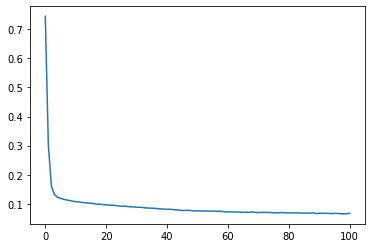

################################################################################
ACCURACY: 
0.975454568862915


In [ ]:
#UNCOMMENT when submitteing: from Data_Loaders import Data_Loaders
#from Networks import Action_Conditioned_FF

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


def train_model(no_epochs):

    batch_size = 5  #<5 seems to be much better for Acc than >5 or something like 16 #taken from part 2 .py file
      #WHAT EXACTLY DOES BATCH_SIZE DO & HOW DOES IT AFFECT PERFORMANCE?? 
    data_loaders = Data_Loaders(batch_size)
    model = Action_Conditioned_FF()

  #added by me
    loss_function=torch.nn.BCELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=0.01)
# --------


    losses = []

    min_loss = model.evaluate(model, data_loaders.test_loader, loss_function)
    print(min_loss)
    losses.append(min_loss)


    for epoch_i in range(no_epochs):
      #---------
        model.train()
        acc_loss = 0 
        num_batch = 0

        for indx,batchdict in enumerate(data_loaders.train_loader):
              num_batch+=1
              # Clear gradients
              optimizer.zero_grad()
  
              in_batch = batchdict['input']
                 #need to get Tensor from 'Inputs' --> model(inputs)
              pred = torch.flatten(model(in_batch))
    
              label_batch = batchdict['label']
            
              loss = loss_function(pred, label_batch)  #need to use Tensor of 'Labels' as y_batch here
              acc_loss += loss.item()

#              losses.append(loss)

              loss.backward()
              # Update the parameters
              optimizer.step()
      
        epoch_loss = acc_loss / num_batch
        if (epoch_i+1)%10 == 0:
             print('epoch:', epoch_i+1,',loss=',loss.item())
             print('epoch:', epoch_i+1,',AVG loss=',epoch_loss)
        
        losses.append(epoch_loss)

           
    torch.save(model.state_dict(), 'saved/saved_model.pkl',_use_new_zipfile_serialization=False)


    plt.plot(losses)
    plt.show()
    #Accuracy
    #i think this is where i actually Test the Model..? where i actually USE the Test Set??  or is it supposed to be used somewhere else? 
    print("#"*80)
    print("ACCURACY: ")
    data_loaders = Data_Loaders(5000) #idk if BatchSize should be the FULL amount for Test or a sub-batch?? 
    for indx,batchdict in enumerate(data_loaders.test_loader):
      in_batch = batchdict['input']
      y_test = batchdict['label']

      with torch.no_grad():
        y_pred=torch.flatten(model(in_batch)) #using torch.flatten again.. 
        y_pred_class=y_pred.round()
        accuracy=(y_pred_class.eq(y_test).sum())/float(y_test.shape[0]) #what is 'y_test'?? 
        print(accuracy.item())


 
if __name__ == '__main__':
    no_epochs = 100 #just trying 10 for now to Test, later use 100
    train_model(no_epochs)

   


In [ ]:
0.9522727131843567


In [ ]:
%cd ../
#%cd assignment_part4
%cd assignment2_part1

#%cd drive/MyDrive/School/CSE 571/Assignment2/assignment_part4

/content/drive/My Drive/School/CSE 571/Assignment2
/content/drive/My Drive/School/CSE 571/Assignment2/assignment2_part1


In [ ]:
from Data_Loaders import Data_Loaders
from Networks import Action_Conditioned_FF

import torch
import torch.nn as nn
import matplotlib.pyplot as plt


def train_model(no_epochs):

    batch_size = 5  
    data_loaders = Data_Loaders(batch_size)
    model = Action_Conditioned_FF()

    #added by me
    loss_function=torch.nn.BCELoss()
    optimizer=torch.optim.SGD(model.parameters(),lr=0.01)
    # --------

    losses = []
    min_loss = model.evaluate(model, data_loaders.test_loader, loss_function)
    losses.append(min_loss)
    

    for epoch_i in range(no_epochs):
        model.train()
        for idx, sample in enumerate(data_loaders.train_loader): # sample['input'] and sample['label']

              optimizer.zero_grad()

              in_batch = batchdict['input']
              pred = torch.flatten(model(in_batch))

              label_batch = batchdict['label']
 
              loss = loss_function(pred, label_batch)  #need to use Tensor of 'Labels' here

              losses.append(loss)
              loss.backward()

              # Update the parameters
              optimizer.step()

      torch.save(model.state_dict(), 'saved/saved_model.pkl',_use_new_zipfile_serialization=False)

if __name__ == '__main__':
    no_epochs =
    train_model(no_epochs)


In [ ]:
%cd ../
%cd assignment_part4
#%cd assignment2_part1

/content/drive/My Drive/School/CSE 571/Assignment2
/content/drive/My Drive/School/CSE 571/Assignment2/assignment_part4


In [ ]:
from SteeringBehaviors import Wander, Seek
import SimulationEnvironment as sim
#UNCOMMENT FOR NOW from Networks import Action_Conditioned_FF

import pickle
import numpy as np
import torch
import numpy.linalg as la


def get_network_param(sim_env, action, scaler):
    sensor_readings = sim_env.raycasting()
    network_param = np.append(sensor_readings, [action, 0]) #unutilized 0 added to match shape of scaler
    network_param = scaler.transform(network_param.reshape(1,-1))
    network_param = network_param.flatten()[:-1]
    network_param = torch.as_tensor(network_param, dtype=torch.float32)
    return network_param

def goal_seeking(goals_to_reach):
    sim_env = sim.SimulationEnvironment()
    action_repeat = 100
    # steering_behavior = Wander(action_repeat)
    steering_behavior = Seek(sim_env.goal_body.position)

    #load model
    model = Action_Conditioned_FF()
    model.load_state_dict(torch.load('saved/saved_model.pkl'))
    model.eval()

    #load normalization parameters
    scaler = pickle.load( open("saved/scaler.pkl", "rb"))

    accurate_predictions, false_positives, missed_collisions = 0, 0, 0
    #getting 0 Missed Collisions and something below 10 for False positives gives full.

    robot_turned_around = False
    actions_checked = []
    goals_reached = 0
    while goals_reached < goals_to_reach:

        seek_vector = sim_env.goal_body.position - sim_env.robot.body.position
        if la.norm(seek_vector) < 50:
            sim_env.move_goal()
            steering_behavior.update_goal(sim_env.goal_body.position)
            goals_reached += 1
            continue

        action_space = np.arange(-5,6)
        actions_available = []
        for action in action_space:
            network_param = get_network_param(sim_env, action, scaler)
            prediction = model(network_param)
            if prediction.item() < .25:
                actions_available.append(action)

        if len(actions_available) == 0:
            sim_env.turn_robot_around()
            continue

        action, _ = steering_behavior.get_action(sim_env.robot.body.position, sim_env.robot.body.angle)
        min, closest_action = 9999, 9999
        for a in actions_available:
            diff = abs(action - a)
            if diff < min:
                min = diff
                closest_action = a

        steering_force = steering_behavior.get_steering_force(closest_action, sim_env.robot.body.angle)
        for action_timestep in range(action_repeat):
            _, collision, _ = sim_env.step(steering_force)
            if collision:
                missed_collisions+=1
                steering_behavior.reset_action()
                break
    
    print(missed_collisions)


if __name__ == '__main__':
    goals_to_reach = 10
    goal_seeking(goals_to_reach)


# TODO: 

1.   Make sure what i have Works given the Entire Project instrucs (including the Robot simulation thing.. )
- CONFIRM the amount of Data i should be training on?? (rn only 100 samples)
--- NO! i SUBMIT only 100 samples but need to TRAIN on much much more!
- *saved_model.pkl & scaler.pkl?* apparently 'scaler.pkl' already saved under Part 2 so just need to submit that from folder, while i need to ADD A SAVER for my Model to get SAVED_MODEL.PKL (i think, unless it's already there somewhere..)
- apparently i don't submmit the 'train.py' but just the 'networks.py' for part 4?? if so --> i'll need to Edit Networks.py a lot to carry the train.py thing.. but idfk if the instrucs are accurate?? 
> Part 4 Evaluation: "0-7 points. 3% of the max score will be deducted for every missed collision. 1% of the max
score will be deducted for every false positive above 10.
- part 3 asks you to submit Networks.py as well btw. 

2.   Add the "Output_CSV" funciton in the Part 1.. (idk if that's necessary? as i'm apparently not submitting that Part 1 at all and just the .csv...???)
3. get the Evaluate Funciton to work & call it from Train Loop

4. add a Test Function or Class OUTSIDE of the Train class/func (i think?)
5. Edit the Part 2 BALANCING thing, but try not to use 'train_test_split' as that requires (i think) a pkg i wasn't given.. 
- maybe i can just hand-balance them?? idk if they actually need it to be balanced by code, as for part 1 i'm just submitting the CSV used... for part 2 though, i am submitting the 'DataLoaders.py'.. 





"You will edit Train_models to train the model and make modifications to your network to minimize loss.  Dont forget you also have to output your model for submission

thank you! so it is right that we initialize the loss_function and optimizer in train_model, but modify networks for the hidden layers and parameters?

@Kexin: You can edit Network.py for Part 4 even after submitting it for Part 2"






In [ ]:
batch_size = 16
data_loaders = Data_Loaders(batch_size)

for i,j in data_loaders.train_loader:
    print(i,j)

In [ ]:
x = torch.randn((20,6))
model = Action_Conditioned_FF()
model(x)

In [ ]:
class myCrazyNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Define all Layers Here
        self.lin1 = nn.Linear(784, 30)
        self.lin2 = nn.Linear(30, 784)
        self.lin3 = nn.Linear(30, 10)
        
    def forward(self, x):
        # Connect the layer Outputs here to define the forward pass
        x_lin1 = self.lin1(x)
        x_lin2 = x + self.lin2(x_lin1)
        x_lin2 = self.lin1(x_lin2)
        x = self.lin3(x_lin2)
        return x

In [ ]:
x = torch.randn((100,784))
model = myCrazyNeuralNet()
model(x)

# Zipping Submissions


In [ ]:
%cd ../
%cd Submissions
%ls

/content/drive/My Drive/School/CSE 571/Assignment2
/content/drive/My Drive/School/CSE 571/Assignment2/Submissions
Networks.py  saved/  submission.zip


In [ ]:
'''
Zip Submission
'''
from zipfile import ZipFile

with ZipFile('submission.zip', 'w') as myzip:
    myzip.write('Networks.py')
    myzip.write('saved/saved_model.pkl')
    myzip.write('saved/scaler.pkl')


FileNotFoundError: ignored